# Depth-time Hovmoller plot

This recipe shows how to calculate a depth-time Hovmoller plot of 1-year anomaly of globally-averaged of conservative temperature salinity from ACCESS-OM2 between Jan 1989 and Dec 2018.

#### Converting to MOM6

To convert to MOM6 you will need to change the following variables:

| MOM5 | MOM6 |
|---|---|
| xt_ocean | xh |
| yt_ocean | yh |
| st_ocean | z_l |
| temp$\text{*}$ | thetao$\text{*}$ |
| dxt | dxt |
| dyt | dyt |
| area_t$\text{**}$ | areacello$\text{**}$ | 

$\text{*}$Note that in MOM5 `temp` describes conservative temperature, and in MOM6 `thetao` describes potential temperature.  
$\text{**}$Area variables are not used in this recipe, but may be needed according to how you define your area mask on a case-by-case basis. 

## Recipe for MOM5

In [1]:
import numpy as np
import xarray as xr
import intake

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
import cmocean.cm as cm

from dask.distributed import Client

In [2]:
client = Client(threads_per_worker = 1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38001 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38001/status,
Dashboard: /proxy/38001/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37379,Workers: 14
Dashboard: /proxy/38001/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:43485,Total threads: 1
Dashboard: /proxy/33125/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:42027,


In [3]:
# Import your experiment from the catalog
catalog = intake.cat.access_nri
experiment = '1deg_jra55_iaf_omip2_cycle1'  # 1-deg experiment

In [4]:
def load_var(experiment, variable, frequency, start_time=None, end_time=None):

    cat_subset = catalog.search(name = experiment)

    var = cat_subset[experiment].search(
        variable = variable, frequency = frequency, variable_cell_methods='time: mean'
        ).to_dask(xarray_open_kwargs = dict(use_cftime=True,chunks={}),
                  xarray_combine_by_coords_kwargs = dict(compat="override", data_vars="minimal", coords="minimal")
                 )[variable]

    var = var.sel(time=slice(start_time, end_time))

    return var

Loading the variables

In [5]:
temperature = load_var(experiment, 'temp', '1mon')

Compute anomalies relative to the first year (assuming monthly output here)

In [6]:
temperature_anomaly = temperature - temperature.isel(time=slice(0, 12)).mean('time')

Next, we load cell area (denoted as $a(x,y,z)$) to construct the total ocean area as a function of depth, $A$, namely
$$ A(z) = \sum_x \sum_y a(x,y,z)$$


We load `dxt` and `dyt` and compute a masked version of cell area; we also use a slight hack to divide temperature by itself and thereby get a 3-dimensional cell area mask that is needed to create $A(z)$.

In [8]:
cat_subset = catalog.search(name = experiment)

dxt = cat_subset[experiment].search(variable = 'dxt', frequency = 'fx', path=".*output000.*").to_dask()['dxt']
dyt = cat_subset[experiment].search(variable = 'dyt', frequency = 'fx', path=".*output000.*").to_dask()['dyt']
cell_area = dxt * dyt

## Make a mask to get vertical variation of area
temp1 = temperature.isel(time=0)
cell_mask = temp1 / temp1

total_area = (cell_area * cell_mask).sum({'xt_ocean', 'yt_ocean'}).load()

Now, the mean temperature at each time level can then be computed as 
$$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \, \tilde{\theta}(x,y,z,t)}{A(z)}$$
where $T$ is the globally average temperature and $\tilde{\theta}$ is the anomaly of the conservative temperature.

In [9]:
### Temperature hovmoller
temperature_hov = (cell_area * temperature_anomaly).sum({'xt_ocean', 'yt_ocean'}) / total_area
temperature_hov = temperature_hov.compute()

In [10]:
def plot_hovmoller(fsize = 14, date_format = mdates.DateFormatter('%Y')):
    
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['xtick.labelsize'] = fsize-2
    plt.rcParams['ytick.labelsize'] = fsize-2
    
    fig = plt.figure(figsize = (10, 6))
    grid = GridSpec(100, 100)
    
    ax = [fig.add_subplot(grid[:30, :30]),
          fig.add_subplot(grid[32:, :30])]
    
    for i in range(len(ax)):
        ax[i].xaxis.set_major_formatter(date_format)
        ax[i].tick_params(axis='x', labelrotation=45)
    
    return fig, ax

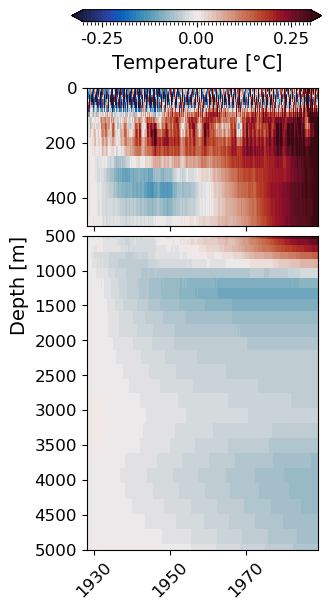

In [11]:
fig, ax = plot_hovmoller(fsize = 14)

levels_temperature = np.arange(-0.3, 0.31, 0.01)

shelf_temp = temperature_hov.plot(ax = ax[0],
                                  levels = levels_temperature,
                                  x = 'time',
                                  y = 'st_ocean',
                                  add_colorbar = False,
                                  label = None,
                                  cmap = cm.balance)

temperature_hov.plot(ax = ax[1],
                        levels = levels_temperature,
                        x = 'time',
                        y = 'st_ocean',
                        add_colorbar = False,
                        label = None,
                        cmap = cm.balance)

## Beautification details
ax[0].set_ylim(500, 0)
ax[0].set_ylabel("")
ax[0].set_xlabel("")
ax[0].set_xticklabels([])
ax[1].set_ylabel("Depth [m]",loc="top")
ax[1].set_ylim(5000, 500)
ax[1].set_xlabel("") # or ax[1].set_xlabel("Time")

# Colorbars
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(shelf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_1.set_label("Temperature [$\degree$C]")


for cbar in [cbar_1]:
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar.locator = tick_locator
    cbar.update_ticks()